<a href="https://colab.research.google.com/github/hikmatfarhat-ndu/CSC645/blob/master/6zMixedData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

In [ ]:
!git clone https://github.com/emanhamed/Houses-dataset


In [2]:
import pandas as pd
df=pd.read_csv("Houses-dataset/Houses Dataset/HousesInfo.txt",header=None,delim_whitespace=True,
               names=["bedrooms","bathrooms","size","zipcode","price"])

In [ ]:
df[0:10]

count the number of houses per zipcode

In [3]:
zipcodes=df['zipcode'].value_counts().keys().tolist()
counts=df['zipcode'].value_counts().tolist()

remove all the entries with zipcodes containing less than 20 houses

In [4]:
for count,zipcode in zip(counts,zipcodes):
  if count<20:
    idx=df[df['zipcode']==zipcode].index
    df.drop(idx,inplace=True)

In [ ]:
df[0:10]

In [5]:
import cv2

image_list=[]
prefix="Houses-dataset/Houses Dataset/"
suffix="_frontal.jpg"
for idx in df.index.tolist():
  path=prefix+str(idx)+suffix
  img=cv2.imread(path)
  img=cv2.resize(img,(48,48))
  image_list.append(img)

In [6]:

import numpy as np
images=np.stack(image_list)

In [ ]:
images.shape

In [7]:
images=images/255.

In [8]:
values=df.values
prices=values[:,4]
max_price=prices.max()
prices=prices/max_price

bedrooms=values[:,0]
bathrooms=values[:,1]
size=values[:,2]
max_size=size.max()
size=size/max_size
zipcodes=values[:,3]
max_zipcodes=zipcodes.max()
zipcodes=tf.one_hot(zipcodes,max_zipcodes).numpy()

In [9]:
#features=np.hstack([bedrooms,bathrooms,size,zipcodes])
nsamples=384
bathrooms=bathrooms.reshape(nsamples,1)
bedrooms=bedrooms.reshape(nsamples,1)
size=size.reshape(nsamples,1)
features=np.hstack([bedrooms,bathrooms,size,zipcodes])
features.shape

(384, 94534)

In [10]:
train_images=images[0:300]
test_images=images[300:nsamples]
train_features=features[0:300]
test_features=features[300:nsamples]
train_prices=prices[0:300]
test_prices=prices[300:nsamples]


In [11]:
from tensorflow.keras.layers import Dense,Input,concatenate,Flatten
from tensorflow.keras.models import Model


In [12]:
def get_features_model():
  features_input=Input(shape=(train_features.shape[1]),name="features_input")
  features_layers=Dense(32,activation="relu")(features_input)
  features_layers=Dense(16,activation="relu")(features_layers)
  features_output=Dense(1,activation="linear",name="features_output")(features_layers)
  model=Model(inputs=features_input,outputs=features_output)
  return model


In [13]:
def get_image_model():
  image_input=Input(shape=(48,48,3),name="image_input")
  flatten=Flatten()(image_input)
  image_layers=Dense(64,activation="relu")(flatten)
  image_layers=Dense(32,activation="relu")(image_layers)
  image_layers=Dense(16,activation="relu")(image_layers)
  image_output=Dense(1,activation="linear",name='image_output')(image_layers)
  model=Model(inputs=image_input,outputs=image_output)
  return model

In [14]:
features_model=get_features_model()

In [15]:
image_model=get_image_model()
both=concatenate([features_model.output,image_model.output])
both=Dense(10,activation='relu')(both)
both=Dense(1,activation='linear',name='both_outputs')(both)
model=Model(inputs=[features_model.input,image_model.input],outputs=[both,features_model.output])


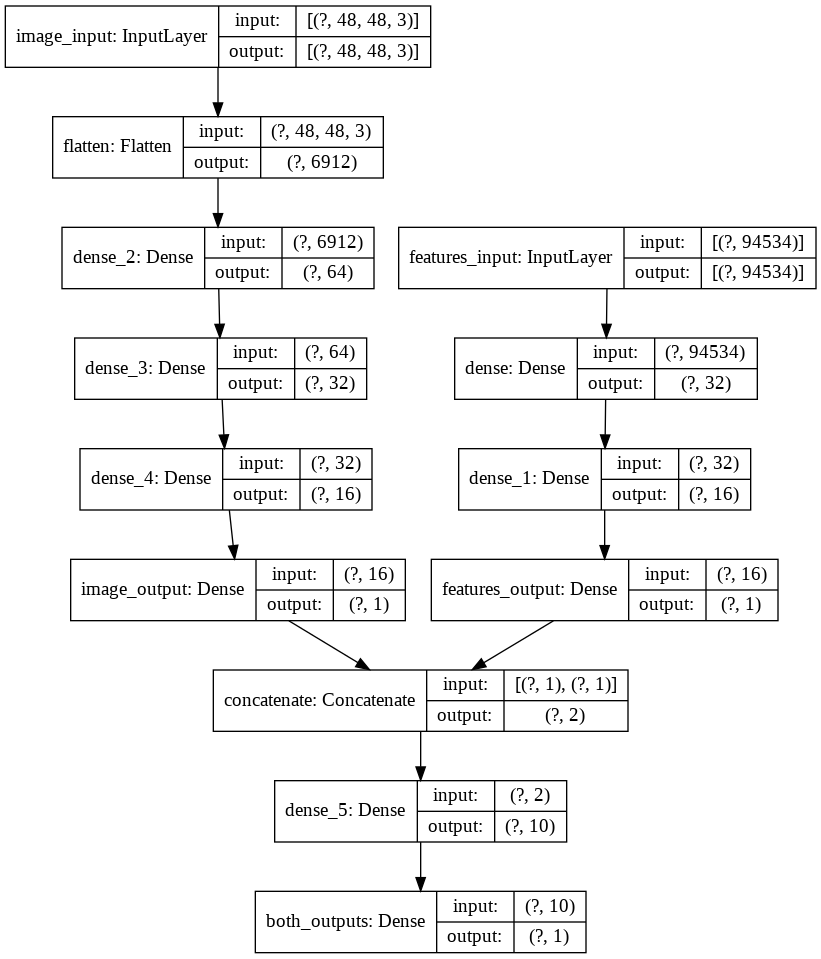

In [16]:
tf.keras.utils.plot_model(model,show_shapes=True)

In [17]:
opt=tf.keras.optimizers.Adam()
model.compile(optimizer=opt,loss='mean_absolute_percentage_error')


In [18]:
model.fit(x=[train_features,train_images],y=train_prices,epochs=100)


Epoch 1/100
10/10 [==============================] - 0s 28ms/step - loss: 1180.2697 - both_outputs_loss: 1100.2108 - features_output_loss: 80.0589
Epoch 2/100
10/10 [==============================] - 0s 28ms/step - loss: 868.3885 - both_outputs_loss: 796.4758 - features_output_loss: 71.9128
Epoch 3/100
10/10 [==============================] - 0s 28ms/step - loss: 231.5365 - both_outputs_loss: 195.8850 - features_output_loss: 35.6514
Epoch 4/100
10/10 [==============================] - 0s 28ms/step - loss: 145.1427 - both_outputs_loss: 104.6443 - features_output_loss: 40.4984
Epoch 5/100
10/10 [==============================] - 0s 28ms/step - loss: 92.2925 - both_outputs_loss: 60.3590 - features_output_loss: 31.9335
Epoch 6/100
10/10 [==============================] - 0s 28ms/step - loss: 78.6230 - both_outputs_loss: 47.1316 - features_output_loss: 31.4914
Epoch 7/100
10/10 [==============================] - 0s 29ms/step - loss: 71.6819 - both_outputs_loss: 45.1909 - features_output_los

In [19]:
model.evaluate([test_features,test_images],test_prices)


3/3 [==============================] - 0s 5ms/step - loss: 48.8988 - both_outputs_loss: 24.9606 - features_output_loss: 23.9382


[48.89879608154297, 24.96062660217285, 23.938169479370117]

In [33]:
predict=np.squeeze(model.predict([test_features[0:6],test_images[0:6]]))
print(predict[0]*max_price)
print(test_prices[0:6]*max_price)
print(predict[1]*max_price)

[618427.9  749176.06 629517.9  534121.3  414918.72 717006.94]
[699000. 639000. 630000. 541000. 529000. 680000.]
[673366.56 675564.8  590756.75 519887.97 413360.44 721341.6 ]


In [34]:
print(100*np.abs(test_prices[0:6]-combined_predict[0])/test_prices[0:6])
print(100*np.abs(test_prices[0:6]-combined_predict[1])/test_prices[0:6])

[11.5267666  17.24195219  0.07652792  1.27148036 21.56546196  5.44219701]
[ 3.66715469  5.72219687  6.22908873  3.90240858 21.86003197  6.07965239]
